# TensorFlow 2.5 tutorial with MNIST dataset

You can find the tutorial on TensorFlow website [here](https://www.tensorflow.org/tutorials/quickstart/beginner?hl=en).

I haven't be using TF sinc the version 2.x release, so I restart from scratch to avoid re-using previous knowledge from TF 1.x.

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

We now load the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset:

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path="/files/cedric/datasets/tensorflow/mnist.npz")

The training dataset contains 60000 gray-scale 28x28 images of hand-written digits. The testing dataset contains 10000 images:

In [4]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

We can visualize each digit with matplotlib:

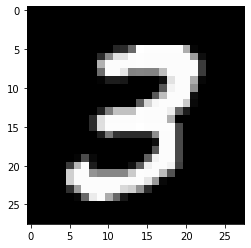

In [5]:
plt.imshow(x_train[7], cmap="gray");

There are 10 different classes in the dataset (one for each digit):

In [6]:
pd.Series(y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

Each array is provided with values ranging from 0 to 255, so we first want to scale the data between 0 and 1:

In [7]:
x_train.max()

255

In [8]:
x_train = x_train / 255.
x_test = x_test / 255.

We can now build a simple model:

- first we flatten the input images into a 784 long vector
- then we add a fully connected layer with 128 neurons with a ReLU activation function
- we use a dropout with a probability of 20% to avoid overfitting
- finally we have 10 output neurons (one for each class)

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

2021-09-12 11:25:58.491381: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


If we run the model with a given input we get the logit scores for each class:

In [10]:
model(x_train[:1]).numpy()

array([[-0.18357086,  0.751819  , -0.15296906,  0.3163001 ,  0.05188823,
        -0.00710952,  0.22708812, -0.34851134, -0.28442356,  0.13784662]],
      dtype=float32)

The expected class is 5 but the network is not trained yet, so prediction is off:

In [11]:
y_train[0]

5

To convert the logits into propabilities, we can use the classical softmax function:

In [12]:
probabilities = tf.nn.softmax(model(x_train[:1])).numpy()

The sum of all the probabilities is 1:

In [13]:
probabilities.sum()

1.0

We can modify the model to add the softmax function. The tutorial advises against this but we should be fine for this example:

In [14]:
model = tf.keras.models.Sequential([model, tf.keras.layers.Softmax()])
model(x_train[:1]).numpy()

array([[0.07504595, 0.19123259, 0.07737799, 0.12371388, 0.09496987,
        0.08952894, 0.11315511, 0.06363478, 0.06784651, 0.10349445]],
      dtype=float32)

An alternative is to use softmax as activation of the last dense layer:

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [16]:
model(x_train[:1]).numpy()

array([[0.08309083, 0.14705843, 0.07757425, 0.13568453, 0.09059241,
        0.1360806 , 0.14437878, 0.0563494 , 0.05097573, 0.07821511]],
      dtype=float32)

Ok, now we need to fit the model. As the targets are provided as integer values (and not one-hot representation), we can use the the sparse cross entropy loss. We tell the loss function that the prediction is a probability (because we have used the softmax activation):

In [17]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

There is now a compilation step to associate the model with a loss function and an optimizer. We also select the accuracy as the main metric to be shown during the training phase:

In [18]:
model.compile(optimizer="adam", loss=loss_fn, metrics=['accuracy'])

And now we can fit the model by step of 5 epochs. You can run the following line so an accuracy of around 0.98 is reached:

In [43]:
model.fit(x_train, y_train, epochs=5);

Epoch 1/5
1875/1875 [==============================] - 1s 530us/step - loss: 0.0321 - accuracy: 0.9894
Epoch 2/5
1875/1875 [==============================] - 1s 522us/step - loss: 0.0318 - accuracy: 0.9887
Epoch 3/5
1875/1875 [==============================] - 1s 517us/step - loss: 0.0309 - accuracy: 0.9895
Epoch 4/5
1875/1875 [==============================] - 1s 516us/step - loss: 0.0290 - accuracy: 0.9905
Epoch 5/5
1875/1875 [==============================] - 1s 514us/step - loss: 0.0261 - accuracy: 0.9912


The number displayed below epoch (1875/1875) is the batch number. This means that by default a mini batch size of 32 is taken.

Now we can evaluate the model on the testing dataset:

In [44]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0883 - accuracy: 0.9802


[0.08829722553491592, 0.9801999926567078]

The first returned value is the loss value and the second one is the accuracy because it's the metrics we have seletected.

The function below enables to visualize the hand-written digit with the probabilities calculated by the network for each class. We then sample a few digits from the testing dataset to check the network predictions:

In [47]:
def plot(model, x):
    y = model(x.reshape(1, -1)).numpy()
    fig = plt.figure(figsize=(8, 4), constrained_layout=True)
    gs = gridspec.GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0, 1])
    ax.barh(range(10), y.reshape(10), tick_label=range(10))
    ax.invert_yaxis()
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(x, cmap="gray")

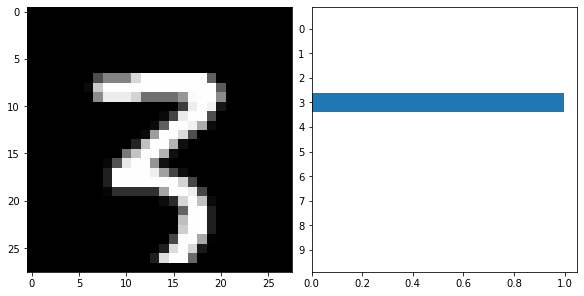

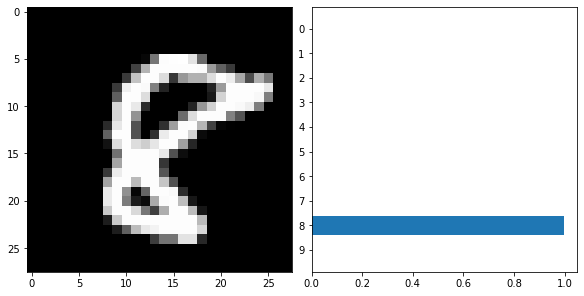

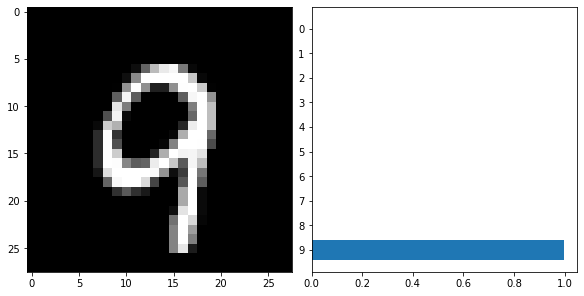

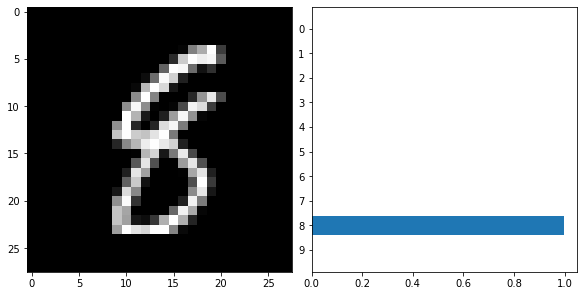

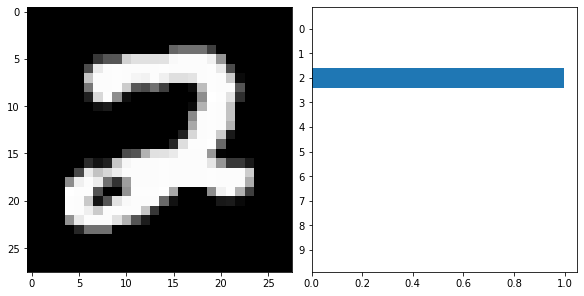

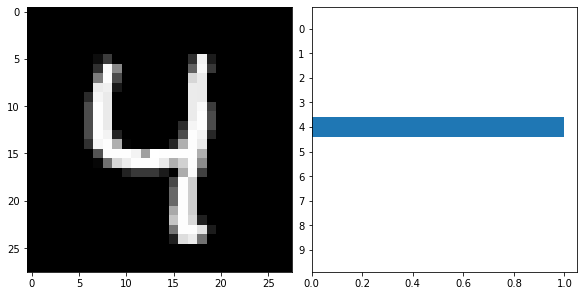

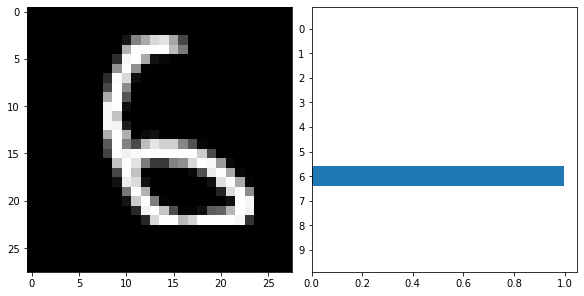

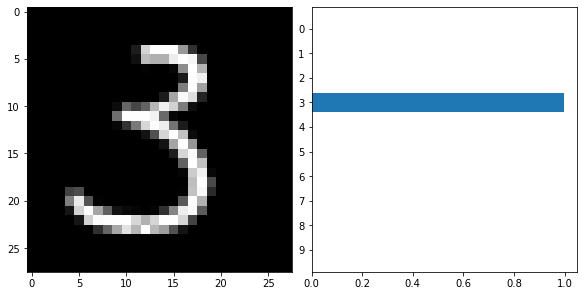

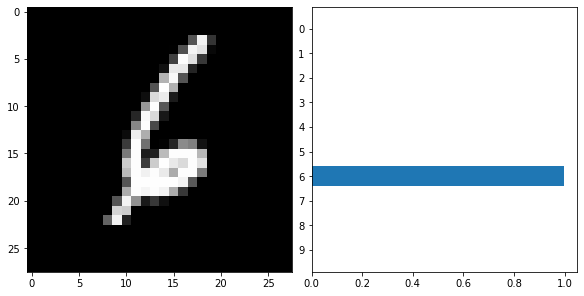

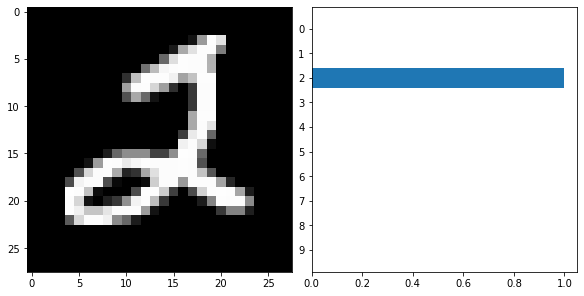

In [48]:
for i in range(10):
    j = np.random.randint(0, 10000)
    plot(model, x_test[j])